In [1]:
import importlib
import preprocessing
importlib.reload(preprocessing)
from preprocessing import *


# CoastalWQL
This is the python notebook for the workflow process as follows:

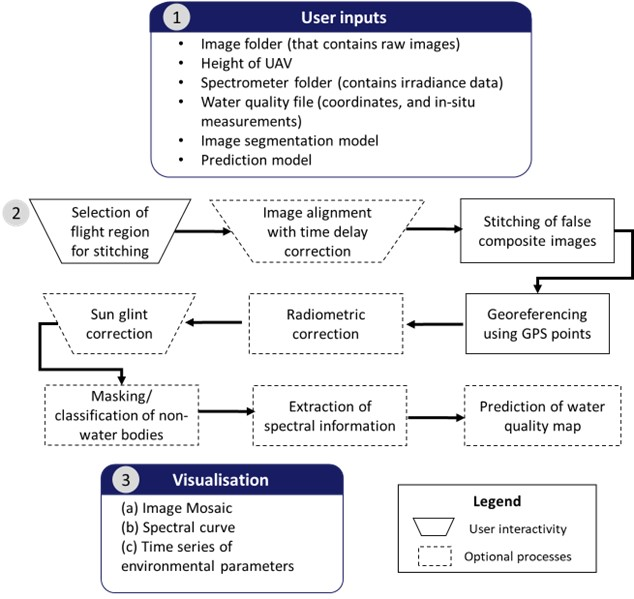

In [68]:
%matplotlib inline
from IPython.display import Image
Image('workflow.jpg')

### Indicate the directory for storing processed images

## Inputs

#### Required inputs

In [69]:
image_fp = "C:/Users/PAKHUIYING/Documents/image_processing/22_08_2021/10-55-00RES1280_EXP0100_GAN0030_BIT08_2EXP0056_GAN0010_RES1280_BIT08"
spectrometer_fp = "C:/Users/PAKHUIYING/Documents/image_processing/22_08_2021/08_22_2021"
fp_store = r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\NanyangLake" #directory to store processed files
prefix = "NanyangLake"
height = 58 #in meters
# if the coordinate selection is used in the GUI_platform, the gps_index_txt file will be automatically saved
gps_index_txt = "inputs/gps_index_test_alignment.txt" #"C:/Users/PAKHUIYING/Documents/image_processing/F3_processed_surveys/test_alignment/2021_08_22/gps_index_test_alignment.txt"
slider = 1400 #in milliseconds (time delay correction)
mask_checkbox = True
classify_checkbox = False
noise_checkbox = True
sunglint_checkbox = True
radiometric_checkbox = True
corrected_indices = None
predict_checkbox = False #True

tss_lat = tss_lon = tss_measurements = None

# if the dynamic alignment is used in the GUI_platform, corrected_fp file will be automatically saved
corrected_fp = "inputs/corrected_indices.json" #r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\test_alignment\2021_08_22\corrected_indices.json" #corrected image indices (optional)
corrected_indices = None
line_start = 0
line_stop = 1
r,g,b = 38,23,15

with open(gps_index_txt, "r") as f:
    gps_indices = f.readlines()
gps_indices = [int(i.replace('\n','')) for i in gps_indices]
gps_indices.sort()

#------optional (can comment out)--------
with open(corrected_fp, "r") as read_file:
    corrected_indices = json.load(read_file)
corrected_indices = [(i['start'],i['stop']) for i in corrected_indices]


#### Sun glint correction inputs (optional)

In [70]:
sunglint_json_fp = None
reflectance_glint = None
bbox = None
#---comment out if there is no sunglint correction---------
# Note that sunglint_json_fp is only automatically generated when using GUI_platform.py

sunglint_json_fp = "inputs/sunglint_correction_test_alignment.txt" #r"C:\Users\PAKHUIYING\OneDrive - Nanyang Technological University\NTU\image_processing\F3_processed_images\2022_08_25_2\sunglint_correction_2022_08_25_13-21-00.txt"

with open(sunglint_json_fp,"r") as cf:
        bbox = json.load(cf)

#### WQL inputs (optional)

In [71]:
wql_csv = r"inputs\wql.csv"
tss_df = pd.read_csv(wql_csv,engine='python')
tss_lat = tss_df.iloc[:,4].tolist()
tss_lon = tss_df.iloc[:,5].tolist()
tss_measurements = tss_df.iloc[:,-2].tolist()
tss_df.head()

#### Image segmentation inputs (optional)

In [2]:
#xgb_seg_fp = r"C:\Users\PAKHUIYING\Documents\Deep_Learning\image_segmentation\saved_images\XGBoost_py39\xgb_segmentation.json" #for python =3.9
xgb_seg_fp = r"Models\image_segmentation\xgb_segmentation.json" #for python=3.6
xgb_seg_model = load_xgb_segmentation_model(xgb_seg_fp)

#### Prediction inputs (optional)

In [73]:
if predict_checkbox is True:
    model_fp = r"Models\turbidity_prediction\XGB_corrected_trimmed100_1.json" #XGBoost model
    # model_fp = r"Models\turbidity_prediction\saved_models\DNN_corrected_trimmed100_1" #DNN model
    model_type = "XGBoost" #If XGBoost model is used, change to "XGBoost", else if DNN model is used, change to "DNN"
    covariates_index_list = "4:15,33:38,43:46,53:54" #indices of covariates
    covariates_index_list = covariates_str_to_list(covariates_index_list)
    downsample_slider = 40

# Updated notes on prediction models
# Our team is currently working on a project with confidential information, and thus model trained on the confidential information cannot be disclosed

In [74]:
gps_df = import_gps(image_fp)
unique_gps_df = get_unique_df(gps_df)
test_gps_index = gps_indices
indexes_list = gps_to_image_indices(unique_gps_df,image_fp,test_gps_index,slider)
print("Original indices: {}".format(indexes_list))
if corrected_indices is not None:
    indexes_list = corrected_indices
print("New indices: {}".format(indexes_list))
reverse_boolean_list = rev_boolean_list(unique_gps_df,test_gps_index)

gps file path:C:/Users/PAKHUIYING/Documents/image_processing/22_08_2021/10-55-00RES1280_EXP0100_GAN0030_BIT08_2EXP0056_GAN0010_RES1280_BIT08/UAV/gps_10-56-2-217.csv
Original indices: [(651, 2209), (2998, 4511), (5335, 6946), (7685, 9348), (9987, 11594), (12329, 13893), (14670, 16221), (16952, 18517), (19251, 20859), (21681, 23341), (24061, 25630)]
New indices: [(663, 2216), (3004, 4521), (5347, 6956), (7695, 9357), (9997, 11604), (12339, 13902), (14680, 16231), (16961, 18528), (19260, 20867), (21690, 23351), (24073, 25640)]


## Image Alignment (optional)

In [75]:
extended_rgb = ExtendedRGB(image_fp,gps_indices,height, unique_gps_df)
general_dict,datetime_list = extended_rgb.main()

corrected_img_start_index: 300, corrected_img_stop_index:4980
Before correction shape:(1024, 5000, 3)
After correction shape:(1024, 4681, 3)
corrected_img_start_index: 20, corrected_img_stop_index:4562
Before correction shape:(1024, 4868, 3)
After correction shape:(1024, 4543, 3)
corrected_img_start_index: 312, corrected_img_stop_index:5133
Before correction shape:(1024, 5153, 3)
After correction shape:(1024, 4822, 3)
corrected_img_start_index: 20, corrected_img_stop_index:5006
Before correction shape:(1024, 5306, 3)
After correction shape:(1024, 4987, 3)
corrected_img_start_index: 309, corrected_img_stop_index:5133
Before correction shape:(1024, 5153, 3)
After correction shape:(1024, 4825, 3)
corrected_img_start_index: 20, corrected_img_stop_index:4712
Before correction shape:(1024, 5018, 3)
After correction shape:(1024, 4693, 3)
corrected_img_start_index: 300, corrected_img_stop_index:4959
Before correction shape:(1024, 4979, 3)
After correction shape:(1024, 4660, 3)
corrected_img_st

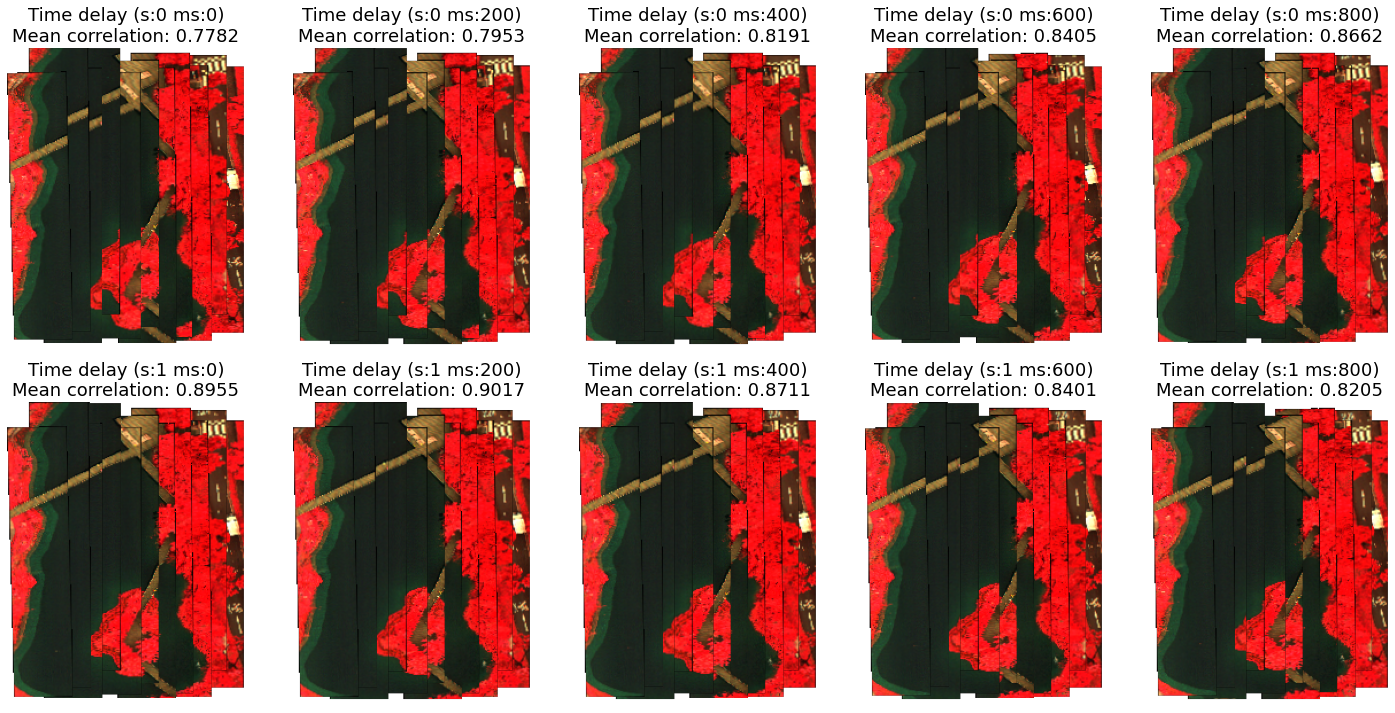

In [76]:
time_corrections = list(range(0,2000,200))
fig,axes = plt.subplots(2,ceil(len(time_corrections)/2),figsize=(20,10))

for i,(t,ax) in enumerate(zip(time_corrections,axes.flatten())):
    s,ms = divmod(t,1000)
    live_correction = LiveCorrection(general_dict,datetime_list,time_delay=t,scale=20)
    img_resize_list, correction_bytes_list,bckgrnd_attr,bbox_list = live_correction.main()
    corr_coeff_list,_ = calculate_correlation_overlap(img_resize_list)
    corr_coeff_avg = np.nanmean(corr_coeff_list)
    for arr in img_resize_list:
        ax.imshow(arr)
    ax.set_title('Time delay (s:{} ms:{})\nMean correlation: {:.4f}'.format(s,ms,corr_coeff_avg),fontdict={'fontsize':18})
    ax.set_axis_off()

# plt.rc('axes',titlesize = 15)
plt.tight_layout()
plt.show()

In [77]:
# # select the most appropriate time delay correction e.g.1200
live_correction = LiveCorrection(general_dict,datetime_list,time_delay=1200,scale=20)
# select the directory where you want to save the corrected_indices
live_correction.main()
corrected_indices_fp = fp_store #r"C:\Users\PAKHUIYING\OneDrive - Nanyang Technological University\NTU\image_processing\F3_processed_images\2022_01_13_2"
live_correction.save_corrected_indices(corrected_indices_fp)

corrected_fp = join(fp_store,"corrected_indices.json") #r"C:\Users\PAKHUIYING\OneDrive - Nanyang Technological University\NTU\image_processing\F3_processed_images\2022_01_13_2\corrected_indices.json" #corrected image indices (optional)

# Load corrected indices
with open(corrected_fp, "r") as read_file:
    corrected_indices = json.load(read_file)
corrected_indices = [(i['start'],i['stop']) for i in corrected_indices]

print(corrected_indices)

corrected_img_start_index: 135, corrected_img_stop_index:4794
Before correction shape:(1024, 5000, 3)
After correction shape:(1024, 4660, 3)
corrected_img_start_index: 191, corrected_img_stop_index:4742
Before correction shape:(1024, 4868, 3)
After correction shape:(1024, 4552, 3)
corrected_img_start_index: 132, corrected_img_stop_index:4959
Before correction shape:(1024, 5153, 3)
After correction shape:(1024, 4828, 3)
corrected_img_start_index: 194, corrected_img_stop_index:5180
Before correction shape:(1024, 5306, 3)
After correction shape:(1024, 4987, 3)
corrected_img_start_index: 132, corrected_img_stop_index:4953
Before correction shape:(1024, 5153, 3)
After correction shape:(1024, 4822, 3)
corrected_img_start_index: 197, corrected_img_stop_index:4886
Before correction shape:(1024, 5018, 3)
After correction shape:(1024, 4690, 3)
corrected_img_start_index: 129, corrected_img_stop_index:4782
Before correction shape:(1024, 4979, 3)
After correction shape:(1024, 4654, 3)
corrected_img

In [78]:
#select number of lines to process
line_start = 0
line_stop = len(test_gps_index)//2
print(f"line start: {line_start}, line stop: {line_stop}")

line start: 0, line stop: 11


# Process images

### Save user-options

In [79]:
config_file = {'-PROCESSED_IMAGES-':fp_store,'-PREFIX-':prefix,'-IMAGE_FOLDER_FILEPATH-':image_fp,\
                '-SPECTRO_FILEPATH-':spectrometer_fp,\
                '-HEIGHT-':height,'-GPS_INDEX_TXT-':gps_index_txt,'-SLIDER-':slider,\
                '-LINE_START-':line_start,'-LINE_END-':line_stop,'rgb_bands':[r,g,b],\
                '-MASK_CHECKBOX-':mask_checkbox,'-CLASSIFY_CHECKBOX-':classify_checkbox,\
                '-RADIOMETRIC_CHECKBOX-':radiometric_checkbox,'-NOISE_CHECKBOX-':noise_checkbox,\
                '-SUNGLINT_CHECKBOX-':sunglint_checkbox,'-PREDICT_CHECKBOX-':predict_checkbox,\
                'corrected_indices':corrected_indices}

if config_file['-PREDICT_CHECKBOX-'] == True:
    prediction_parameters = {'-MODEL_PREDICTORS-':covariates_index_list,'-DOWNSAMPLE_SLIDER-':downsample_slider,'-MODEL_FILEPATH-':model_fp,'model_type':model_type}
    for k,v in prediction_parameters.items():
        config_file[k] = v

with open(join(fp_store,'config_file_{}.txt'.format(config_file['-PREFIX-'])),'w') as cf:
    json.dump(config_file,cf)

#### sun glint correction

In [80]:
try:
    line_glint = bbox['glint']['line']
    start_i,end_i = indexes_list[line_glint]
    test_stitch_class = StitchHyperspectral(fp_store,config_file['-PREFIX-'],config_file['-IMAGE_FOLDER_FILEPATH-'],config_file['-SPECTRO_FILEPATH-'],\
        int(config_file['-HEIGHT-']),line_glint,start_i,end_i,\
        test_gps_index, unique_gps_df,reverse=reverse_boolean_list[line_glint])

    reflectance_glint = test_stitch_class.get_stitched_reflectance() #radiometrically corrected reflectance only for the image line where glint bbox is drawn on
    print("get reflectance glint...")
except Exception as E:
    sunglint_json_fp = None
    reflectance_glint = None

Getting spectroradiometer data...
Performing correction using calibration curve...
Cubic function calibration...
get reflectance glint...


# For python >= 3.7

- If there are no incompatibilities between `tensorflow` and `gdal` in the virtual environment, the entire processing pipeline can be automated in the following code chunk.

- However `python == 3.7` is not used in the `GUI_platform.py`'s venv because of some bugs observed in `PySimpleGUI`

In [81]:
# for line_number in range(line_start, line_stop+1):
#     indexes_list = corrected_indices # overwrite
#     start_i,end_i = indexes_list[line_number]
#     test_stitch_class = StitchHyperspectral(fp_store,config_file['-PREFIX-'],config_file['-IMAGE_FOLDER_FILEPATH-'],config_file['-SPECTRO_FILEPATH-'],\
#                         int(config_file['-HEIGHT-']),line_number,start_i,end_i,\
#                         test_gps_index, unique_gps_df, destriping = config_file['-NOISE_CHECKBOX-'],\
#                         reverse=reverse_boolean_list[line_number])
#     test_stitch_class.view_pseudo_colour(r,g,b) #outputs rgb
#     #-----optional (can comment out)-------------
#     ##-----masking--------------
#     if config_file['-MASK_CHECKBOX-'] is True:
#         print("Performing segmentation...")
#         mask = test_stitch_class.get_mask(xgb_seg_model,type="XGBoost")
#     else:
#         print("Segmentation not conducted...")
#         mask = None
#     ##-----sunglint correction----
#     if config_file['-SUNGLINT_CHECKBOX-'] is True and sunglint_json_fp is not None and reflectance_glint is not None:
#         sgc = SunglintCorrection(test_stitch_class,sunglint_json_fp,reflectance_glint)
#         sgc.sunglint_correction_rgb()
#         sgc_reflectance = sgc.sunglint_correction_reflectance()
#         reflectance = None
#         print("Performing sunglint correction on hyperspectral reflectances...")
#     else:
#         print("No sunglint correction...")
#         config_file['-SUNGLINT_CHECKBOX-'] = False
#         sgc_reflectance = None
#          ##-----radiometric correction--------------
#         if config_file['-RADIOMETRIC_CHECKBOX-'] is True:
#             reflectance = test_stitch_class.get_stitched_reflectance()
#             print("Getting radiometrically corrected reflectances...")
#         else:
#             reflectance = test_stitch_class.get_stitched_uncorrected_reflectance()
#             print("Getting uncorrected reflectances...")
#     ##---------extraction of spectral information
#     if tss_lat is not None:
#         #extraction of spectral information
#         test_stitch_class.get_reflectance_from_GPS(tss_lat,tss_lon,tss_measurements,\
#             radius=2, mask = mask,\
#             glint_corrected_reflectance=sgc_reflectance,reflectance = reflectance)
#     #-----prediction-------------
#     if config_file['-PREDICT_CHECKBOX-'] == True:
#         try: #4:54, #4:15,33:38,43:46,53:54
#             test_stitch_class.get_predicted_image(model=config_file['-MODEL_FILEPATH-'],\
#                 covariates_index_list = config_file['-MODEL_PREDICTORS-'],\
#                 model_type=config_file['model_type'],\
#                 # radiometric_correction=config_file['-RADIOMETRIC_CHECKBOX-'],\
#                 scaling_factor=int(config_file['-DOWNSAMPLE_SLIDER-']),\
#                 glint_corrected_reflectance=sgc_reflectance,reflectance=reflectance)
#             print("Generating prediction map...")
#         except Exception as E:
#             print("No prediction...")
#             pass
#     #------geotransform--------
#     gti = GeotransformImage(test_stitch_class,\
#         mask = mask, classify = config_file['-CLASSIFY_CHECKBOX-'],\
#         transform_predicted_image = config_file['-PREDICT_CHECKBOX-'],\
#         sunglint_correction=config_file['-SUNGLINT_CHECKBOX-'])
#     gti.geotransform_image()

# if tss_lat is not None:
#     test_stitch_class.preprocess_spectral_info(export_to_array=False)

# For python version == 3.6

### Conducts stitching, radiometric calibration and correction, sunglint correction, masking, extraction of spectral information

Use of virtual env where:
- `python=3.6`
- `tensorflow=2.4.1`

However, in this case, the virtual environment is incompatible with `gdal`. So a change in virtual environment is needed for the registration of the images in the next code chunk. 

It is a huge hassle to change the venv midway, but this can be avoided if no tensorflow models are used for predicting the turbidity, and instead e.g. XGBoost model etc are used.


In [89]:
for line_number in range(line_start, line_stop):
    indexes_list = corrected_indices # overwrite
    start_i,end_i = indexes_list[line_number]
    test_stitch_class = StitchHyperspectral(fp_store,config_file['-PREFIX-'],config_file['-IMAGE_FOLDER_FILEPATH-'],config_file['-SPECTRO_FILEPATH-'],\
                        int(config_file['-HEIGHT-']),line_number,start_i,end_i,\
                        test_gps_index, unique_gps_df, destriping = config_file['-NOISE_CHECKBOX-'],\
                        reverse=reverse_boolean_list[line_number])
    test_stitch_class.view_pseudo_colour(r,g,b) #outputs rgb
    #-----optional (can comment out)-------------
    ##-----masking--------------
    if config_file['-MASK_CHECKBOX-'] is True:
        print("Performing segmentation...")
        mask = test_stitch_class.get_mask(xgb_seg_model,type="XGBoost")
    else:
        print("Segmentation not conducted...")
        mask = None
    
    ##-----sunglint correction----
    if config_file['-SUNGLINT_CHECKBOX-'] is True and sunglint_json_fp is not None and reflectance_glint is not None:
        sgc = SunglintCorrection(test_stitch_class,sunglint_json_fp,reflectance_glint)
        sgc.sunglint_correction_rgb()
        sgc_reflectance = sgc.sunglint_correction_reflectance()
        reflectance = None
        print("Performing sunglint correction on hyperspectral reflectances...")
    else:
        print("No sunglint correction...")
        config_file['-SUNGLINT_CHECKBOX-'] = False
        sgc_reflectance = None
        ##-----radiometric correction--------------
        if config_file['-RADIOMETRIC_CHECKBOX-'] is True:
            reflectance = test_stitch_class.get_stitched_reflectance()
            print("Getting radiometrically corrected reflectances...")
        else:
            reflectance = test_stitch_class.get_stitched_uncorrected_reflectance()
            print("Getting uncorrected reflectances...")
    ##---------extraction of spectral information
    if tss_lat is not None:
        #extraction of spectral information
        test_stitch_class.get_reflectance_from_GPS(tss_lat,tss_lon,tss_measurements,\
            radius=2, mask = mask,\
            glint_corrected_reflectance=sgc_reflectance,reflectance = reflectance)
    #-----prediction-------------
    if config_file['-PREDICT_CHECKBOX-'] == True:
        try: #4:54, #4:15,33:38,43:46,53:54
            test_stitch_class.get_predicted_image(model=config_file['-MODEL_FILEPATH-'],\
                covariates_index_list = config_file['-MODEL_PREDICTORS-'],\
                model_type=config_file['model_type'],\
                # radiometric_correction=config_file['-RADIOMETRIC_CHECKBOX-'],\
                scaling_factor=int(config_file['-DOWNSAMPLE_SLIDER-']),\
                glint_corrected_reflectance=sgc_reflectance,reflectance=reflectance)
            print("Generating prediction map...")
        except Exception as E:
            print("No prediction...")
            pass

Performing segmentation...
rgb_fp loaded for masking: C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\NanyangLake\NanyangLake_rgb_image_line_00_663_2216.tif
Getting spectroradiometer data...
Performing correction using calibration curve...
Cubic function calibration...
Performing sunglint correction on hyperspectral reflectances...
Performing segmentation...
rgb_fp loaded for masking: C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\NanyangLake\NanyangLake_rgb_image_line_01_3004_4521.tif
Getting spectroradiometer data...
Performing correction using calibration curve...
Cubic function calibration...
Performing sunglint correction on hyperspectral reflectances...
Performing segmentation...
rgb_fp loaded for masking: C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\NanyangLake\NanyangLake_rgb_image_line_02_5347_6956.tif
Getting spectroradiometer data...
Performing correction using calibration curve...
Cubic function calibration...


c:\Users\PAKHUIYING\Documents\Programming\CoastalWQL\CoastalWQL\preprocessing.py:1941: RuntimeWarning: invalid value encountered in true_divide
  r_b_im = self.img[:,:,0]/self.img[:,:,-1]


Getting spectroradiometer data...
Performing correction using calibration curve...
Cubic function calibration...
Performing sunglint correction on hyperspectral reflectances...
Performing segmentation...
rgb_fp loaded for masking: C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\NanyangLake\NanyangLake_rgb_image_line_07_16961_18528.tif
Getting spectroradiometer data...
Performing correction using calibration curve...
Cubic function calibration...
Performing sunglint correction on hyperspectral reflectances...
Performing segmentation...
rgb_fp loaded for masking: C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\NanyangLake\NanyangLake_rgb_image_line_08_19260_20867.tif
Getting spectroradiometer data...
Performing correction using calibration curve...
Cubic function calibration...
Performing sunglint correction on hyperspectral reflectances...
Performing segmentation...
rgb_fp loaded for masking: C:\Users\PAKHUIYING\Documents\image_processing\F3_proce

### Perform masking and geotransform of images

Use of venv where `python=3.6` is compatible with `gdal`

In [90]:
for line_number in range(line_start, line_stop):
    indexes_list = corrected_indices # overwrite
    start_i,end_i = indexes_list[line_number]
    test_stitch_class = StitchHyperspectral(fp_store,config_file['-PREFIX-'],config_file['-IMAGE_FOLDER_FILEPATH-'],config_file['-SPECTRO_FILEPATH-'],\
                        int(config_file['-HEIGHT-']),line_number,start_i,end_i,\
                        test_gps_index, unique_gps_df, destriping = config_file['-NOISE_CHECKBOX-'],\
                        reverse=reverse_boolean_list[line_number])
    
    ##-----masking--------------
    if config_file['-MASK_CHECKBOX-'] is True:
        print("Performing segmentation...")
        mask = test_stitch_class.get_mask(xgb_seg_model,type="XGBoost")
    else:
        print("Segmentation not conducted...")
        mask = None
    #------geotransform--------
    gti = GeotransformImage(test_stitch_class,\
        mask = mask, classify = config_file['-CLASSIFY_CHECKBOX-'],\
        transform_predicted_image = config_file['-PREDICT_CHECKBOX-'],\
        sunglint_correction=config_file['-SUNGLINT_CHECKBOX-'])
    gti.geotransform_image()

if tss_lat is not None:
    test_stitch_class.preprocess_spectral_info(export_to_array=False)

Performing segmentation...
rgb_fp loaded for masking: C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\NanyangLake\NanyangLake_rgb_image_line_00_663_2216.tif
image obtained from gps indexes (15, 47): C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\NanyangLake\NanyangLake_rgb_image_line_00_663_2216.tif
Flight angle is 89.71
Performing geotransformation...
Upper left corner coord: lat:1.3451248829878186, lon:103.68512562791194
Performing segmentation...
rgb_fp loaded for masking: C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\NanyangLake\NanyangLake_rgb_image_line_01_3004_4521.tif
image obtained from gps indexes (63, 94): C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\NanyangLake\NanyangLake_rgb_image_line_01_3004_4521.tif
Flight angle is 90.04
Performing geotransformation...
Upper left corner coord: lat:1.3451525560052504, lon:103.68508384300256
Performing segmentation...
rgb_fp loaded for masking: C:\Users

## Visualisation

#### view false composite images

In [91]:
vc = ViewCanvas(config_file)
img_resize_list,bytes_list,df,wql_legend = vc.rgb_canvas()

gps file path:C:/Users/PAKHUIYING/Documents/image_processing/22_08_2021/10-55-00RES1280_EXP0100_GAN0030_BIT08_2EXP0056_GAN0010_RES1280_BIT08/UAV/gps_10-56-2-217.csv


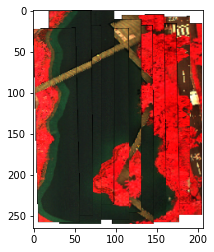

In [92]:
plt.figure()
for i in img_resize_list:
    plt.imshow(i)
if df is not None:
    plt.plot(df['x_general'],i.shape[1]-df['y_general'],'k.')
plt.show()

#### view predicted images (if applicable)

In [ ]:
if config_file['-PREDICT_CHECKBOX-'] == True:
    vc = ViewCanvas(config_file)
    img_resize_list,bytes_list,df,wql_legend = vc.prediction_canvas()
    plt.figure()
    for i in img_resize_list:
        plt.imshow(i)
    plt.show()

### Plot model performance
Only if spectral information from wql points have been extracted

Requires: 
- wql inputs
- prediction

In [ ]:
if (config_file['-PREDICT_CHECKBOX-'] == True) and (tss_lat is not None):
    vc = ViewCanvas(config_file)
    fig = vc.plot_model_performance()
    fig